# Comparing Different CNNs on Augmented MRI Dataset
- This notebook focuses on various CNNs and compares their performance on the Augmented Dataset.
- Only the MRI Images are being here as we think that if it works better on MRI, it will automatically also work good on the CT Scans. Also, we take MRI Images here as it has a higher number of classes compared to CT Images.

In [1]:
# Loading Necessary Libraries

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
import timm
from dotenv import load_dotenv
import os

load_dotenv()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


import numpy as np
import pandas as pd

In [2]:
# Configuring Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
# Fixing seeds for reproducibility

import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data Preprocessing

In [5]:
# Extracting image paths

import glob
from pathlib import Path

image_paths = [] # Store image paths
labels = [] # Store corresponding labels
ds_path = os.getenv("AUGMENTED_DATASET_PATH")

dataset_path = Path(ds_path) / 'MRI'

# Common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']

# Present Classes
image_classes = ['healthy', 'tumor-glioma', 'tumor-meningioma', 'tumor-pituitary']

# Function to get all image paths for a specific class
def get_image_files(folder_path):

    image_files = []
    for extension in image_extensions:
        image_files.extend(glob.glob(str(folder_path / "**" / extension), recursive=True))
    return image_files

# Getting all healthy images
healthy_folder = dataset_path / 'Healthy'
if healthy_folder.exists():
    healthy_images = get_image_files(healthy_folder)
    image_paths.extend(healthy_images)
    labels.extend(['healthy'] * len(healthy_images))
    print(f"Found {len(healthy_images)} Healthy images")
else:
    print(f"Folder not found: {healthy_folder}")

# Getting all tumor images
tumor_folder = dataset_path / 'Tumor'
if tumor_folder.exists():
    for type in ['glioma', 'meningioma', 'pituitary']:
        tumor_images = get_image_files(tumor_folder / type)
        image_paths.extend(tumor_images)
        labels.extend(['tumor-' + type] * len(tumor_images))
        print(f'Found {len(tumor_images)} images of type {type}')
else:
    print(f'Folder Not Found: {tumor_folder}')

print(f"\nTotal number of images: {len(image_paths)}")

print("\n First 5 images and their labels: ")
for i in range(min(5, len(image_paths))):
    print(f"{labels[i]}: {image_paths[i]}")

Found 1500 Healthy images
Found 1510 images of type glioma
Found 1500 images of type meningioma
Found 1500 images of type pituitary

Total number of images: 6010

 First 5 images and their labels: 
healthy: datasets\aug-medical\MRI\Healthy\healthy_aug_albu_0.jpg
healthy: datasets\aug-medical\MRI\Healthy\healthy_aug_albu_1.jpg
healthy: datasets\aug-medical\MRI\Healthy\healthy_aug_albu_10.jpg
healthy: datasets\aug-medical\MRI\Healthy\healthy_aug_albu_100.jpg
healthy: datasets\aug-medical\MRI\Healthy\healthy_aug_albu_1000.jpg


In [6]:
# Converting to a dataframe for easier preprocessing

data_df = pd.DataFrame(zip(image_paths, labels), columns=['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,datasets\aug-medical\MRI\Healthy\healthy_aug_a...,healthy
1,datasets\aug-medical\MRI\Healthy\healthy_aug_a...,healthy
2,datasets\aug-medical\MRI\Healthy\healthy_aug_a...,healthy
3,datasets\aug-medical\MRI\Healthy\healthy_aug_a...,healthy
4,datasets\aug-medical\MRI\Healthy\healthy_aug_a...,healthy


In [7]:
# Train Val Test Split (70-15-15)

train_df, test_df = train_test_split(
    data_df,
    test_size=0.3, # 30% test
    stratify=data_df['labels'], # keep same class proportions
    random_state=7 # for reproducibility
)

test_df, val_df = train_test_split(
    test_df,
    test_size=0.5, # 50% Validation and 50% Test(Finally 15% for both)
    stratify=test_df['labels'],
    random_state=7
)

In [8]:
# Checking for distribution in train and test datasets

print("Train Set: ")
print(train_df['labels'].value_counts(normalize=True))
print("\nTest Set: ")
print(test_df['labels'].value_counts(normalize=True))
print("\nValidation Set: ")
print(val_df['labels'].value_counts(normalize=True))

Train Set: 
labels
tumor-glioma        0.251248
healthy             0.249584
tumor-meningioma    0.249584
tumor-pituitary     0.249584
Name: proportion, dtype: float64

Test Set: 
labels
tumor-glioma        0.250832
tumor-meningioma    0.249723
tumor-pituitary     0.249723
healthy             0.249723
Name: proportion, dtype: float64

Validation Set: 
labels
tumor-glioma        0.251663
tumor-meningioma    0.249446
healthy             0.249446
tumor-pituitary     0.249446
Name: proportion, dtype: float64


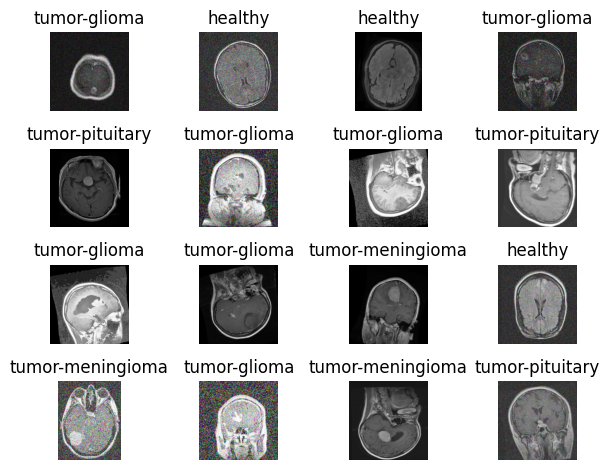

In [9]:
# Data Visualization

n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = train_df.iloc[np.random.randint(low=0, high=train_df.shape[0])]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])

plt.tight_layout()
plt.show()

In [10]:
# Encoding clases to numeric values

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

# Model Creation, Data Loading & Hyperparameters

In [11]:
# Hyperparameters

LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 30

In [12]:
# Model info class

class Model:
    def __init__(self, name, model, weights=None, timm_model=False):
        self.name = name
        if timm_model:
            # model here is actually timm.create_model
            self.model = model(name, pretrained=True)
            data_config = timm.data.resolve_model_data_config(self.model)
            self.transform = timm.data.create_transform(**data_config, is_training=False)
        else:
            self.model = model(weights=weights)
            self.transform = weights.transforms()

# Dataset Class

class dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        img_path = self.dataframe['image_paths'].iloc[index]
        label = self.labels[index]
        image = Image.open(img_path).convert('RGB')
        if(self.transform):
            image = self.transform(image)
        return image, label

- Some models are not present in pytorch(EfficientNet, ViT, InceptionResNet).
- For those, we will use timm(Torch Image Models) from HuggingFace.

In [13]:
# Creating model objects
models = []

# # VGG19
# from torchvision.models import vgg19, VGG19_Weights
# models.append(Model(name='vgg19',
#                     model=vgg19,
#                     weights=VGG19_Weights.IMAGENET1K_V1))

# # Inception V3
# from torchvision.models import inception_v3, Inception_V3_Weights
# models.append(Model(name='inception_v3',
#                     model=inception_v3,
#                     weights=Inception_V3_Weights.IMAGENET1K_V1))

# # ResNet50
# from torchvision.models import resnet50, ResNet50_Weights
# models.append(Model(name='resnet50',
#                     model=resnet50,
#                     weights=ResNet50_Weights.IMAGENET1K_V1))

# # Wide ResNet50_2
# from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
# models.append(Model(name='wide_resnet50_2',
#                     model=wide_resnet50_2,
#                     weights=Wide_ResNet50_2_Weights.IMAGENET1K_V2))

# DenseNet121
from torchvision.models import densenet121, DenseNet121_Weights
models.append(Model(name='densenet121',
                    model=densenet121,
                    weights=DenseNet121_Weights.IMAGENET1K_V1))

# DenseNet169
from torchvision.models import densenet169, DenseNet169_Weights
models.append(Model(name='densenet169',
                    model=densenet169,
                    weights=DenseNet169_Weights.IMAGENET1K_V1))

# # MobileNet V2
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# models.append(Model(name='mobilenet_v2',
#                     model=mobilenet_v2,
#                     weights=MobileNet_V2_Weights.IMAGENET1K_V2))

# # MobileNet V3 Small
# from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
# models.append(Model(name='mobilenetv3_small',
#                     model=mobilenet_v3_small,
#                     weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1))

# # MobileNet V3 Large
# from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
# models.append(Model(name='mobilenetv3_large',
#                     model=mobilenet_v3_large,
#                     weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2))


#  Models from timm (EfficientNet, ViT, InceptionResNet)

import timm

# # EfficientNet
# models.append(Model(name='efficientnet_b0',
#                     model=timm.create_model,
#                     timm_model=True))

# # ViT
# models.append(Model(name='vit_base_patch16_224',
#                     model=timm.create_model,
#                     timm_model=True))

# # InceptionResNetV2
# models.append(Model(name='inception_resnet_v2',
#                     model=timm.create_model,
#                     timm_model=True))


In [14]:
models[0].model.classifier.in_features

1024

In [15]:
# Function to modify model for 4 classes
def modify_model_for_classification(model_obj, num_classes: int):
    """
    Modify the classifier layer of different models to output num_classes
    Replace entire classifier with single Linear layer
    """
    model = model_obj.model
    model_name = model_obj.name

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
    
    if 'vgg' in model_name:
        # VGG models: Replace entire classifier
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif model_name == "inception_resnet_v2":
        # InceptionResNetV2 (timm)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
        
    elif 'resnet' in model_name or 'wide_resnet' in model_name:
        # Torchvision ResNets
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
    elif 'densenet' in model_name:
        # DenseNet
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        
    elif 'mobilenet' in model_name:
        if 'mobilenet_v2' in model_name:
            in_features = model.classifier[1].in_features
            model.classifier = nn.Linear(in_features, num_classes)
        else:
            # MobileNet V3
            in_features = None
            for layer in model.classifier:
                if isinstance(layer, nn.Linear):
                    in_features = layer.in_features
                    break
            if in_features is not None:
                model.classifier = nn.Linear(in_features, num_classes)
                
    elif model_name == 'inception_v3':
        # Inception V3 (torchvision)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        if hasattr(model, 'AuxLogits'):
            aux_in_features = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # ---------------- TIMM MODELS ---------------- #
    elif model_name.startswith("efficientnet"):
        # EfficientNet (timm)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif model_name.startswith("vit"):
        # Vision Transformer (timm)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)

    

    # Enable gradients for the new classifier
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Module):
        for param in model.classifier.parameters():
            param.requires_grad = True
    if hasattr(model, "classif") and isinstance(model.classif, nn.Module):
        for param in model.classif.parameters():
            param.requires_grad = True
    if hasattr(model, "fc") and isinstance(model.fc, nn.Module):
        for param in model.fc.parameters():
            param.requires_grad = True
    if hasattr(model, "head") and isinstance(model.head, nn.Module):
        for param in model.head.parameters():
            param.requires_grad = True
    if hasattr(model, "AuxLogits") and hasattr(model.AuxLogits, "fc"):
        for param in model.AuxLogits.fc.parameters():
            param.requires_grad = True
    
    model_obj.model = model
    return model_obj

In [16]:
# Apply model modifications for 4-class classification
print("Modifying models for 4-class classification...")
print("="*50)

for i, model_obj in enumerate(models):
    print(f"Modifying {model_obj.name}...")
    try:
        # Apply the modification
        model_obj = modify_model_for_classification(model_obj, num_classes=4)
        models[i] = model_obj  # Update the model in the list
        print(f"  ✅ {model_obj.name} modified successfully")
        
        # Verify the modification - CORRECTED VERSION
        model = model_obj.model
        try:
            if hasattr(model, 'classifier'):
                if isinstance(model.classifier, nn.Sequential):
                    # Get the last layer in Sequential
                    last_layer = model.classifier[-1]
                    if hasattr(last_layer, 'out_features'):
                        print(f"  📝 Classifier: {len(model.classifier)} layers, output: {last_layer.out_features} classes")
                    else:
                        print(f"  📝 Classifier: {len(model.classifier)} layers (Sequential)")
                else:
                    # Single Linear layer
                    print(f"  📝 Classifier: Single layer, output: {model.classifier.out_features} classes")
            elif hasattr(model, 'classif'):
                # FIXED: classif is a Linear layer, not Sequential
                if isinstance(model.classif, nn.Linear):
                    print(f"  📝 Classif: Single layer, output: {model.classif.out_features} classes")
                else:
                    # If it's Sequential (unlikely for timm models)
                    last_layer = model.classif[-1]
                    if hasattr(last_layer, 'out_features'):
                        print(f"  📝 Classif: {len(model.classif)} layers, output: {last_layer.out_features} classes")
                    else:
                        print(f"  📝 Classif: {len(model.classif)} layers (Sequential)")
            elif hasattr(model, 'fc'):
                if isinstance(model.fc, nn.Sequential):
                    last_layer = model.fc[-1]
                    if hasattr(last_layer, 'out_features'):
                        print(f"  📝 FC layer: {len(model.fc)} layers, output: {last_layer.out_features} classes")
                    else:
                        print(f"  📝 FC layer: {len(model.fc)} layers (Sequential)")
                else:
                    # Single Linear layer
                    print(f"  📝 FC layer: Single layer, output: {model.fc.out_features} classes")
            elif hasattr(model, 'head'):
                if isinstance(model.head, nn.Sequential):
                    last_layer = model.head[-1]
                    if hasattr(last_layer, 'out_features'):
                        print(f"  📝 Head: {len(model.head)} layers, output: {last_layer.out_features} classes")
                    else:
                        print(f"  📝 Head: {len(model.head)} layers (Sequential)")
                else:
                    # Single Linear layer
                    print(f"  📝 Head: Single layer, output: {model.head.out_features} classes")
            else:
                print(f"  📝 No classifier/fc/head/classif found")
        except Exception as verify_error:
            print(f"  ⚠️ Verification error: {verify_error}")
            
    except Exception as e:
        print(f"  ❌ Error modifying {model_obj.name}: {e}")

print("\n" + "="*50)
print("Model modifications complete!")
print("="*50)

Modifying models for 4-class classification...
Modifying densenet121...
  ✅ densenet121 modified successfully
  📝 Classifier: Single layer, output: 4 classes
Modifying densenet169...
  ✅ densenet169 modified successfully
  📝 Classifier: Single layer, output: 4 classes

Model modifications complete!


In [17]:
# Display model summaries with correct input sizes
print("Model Summaries:")
print("=" * 50)

for i, model_obj in enumerate(models):
    print(f"\n{i+1}. {model_obj.name.upper()}")
    print("-" * 30)
    
    # Move model to device first
    model_obj.model = model_obj.model.to(device)
    
    # Determine correct input size based on model
    if 'inception' in model_obj.name:
        input_size = (3, 299, 299)
    else:
        input_size = (3, 224, 224)
    
    try:
        summary(model_obj.model, input_size=input_size, device=device)
    except Exception as e:
        print(f"Error generating summary for {model_obj.name}: {e}")
    
    print("\n" + "="*50)

Model Summaries:

1. DENSENET121
------------------------------
Error generating summary for densenet121: 'list' object has no attribute 'size'


2. DENSENET169
------------------------------
Error generating summary for densenet169: 'list' object has no attribute 'size'



In [18]:
import time
from sklearn.metrics import accuracy_score

# Lists to store results for all models
results = {
    'model_names': [], # Model name
    'train_times': [], # Total train time
    'val_eval_times': [], # Time to do prediction on val dataset
    'final_test_times': [], # Time to do prediction on test dataset
    'train_accuracies': [], # Training accuracy
    'val_accuracies': [], # Validation Accuracy(Check for over/underfitting)
    'final_test_accuracies': [], # Final test accuracy
    'best_epochs': [], # Best epochs
    'final_train_losses': [], # Loss on train set
    'final_val_losses': [], # Loss on val set
    'final_test_losses': [], # Loss on test set
    'train_acc_history': [], # Per epoch train accuracy
    'val_acc_history': [], # Per epoch validation accuracy
    'train_loss_history': [], # Per epoch train loss
    'val_loss_history': [] # Per epoch val loss
}

# Early stopping parameters
PATIENCE = 5  # Number of epochs to wait for improvement
MIN_DELTA = 0.01  # Minimum change to qualify as improvement

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, model_name, epochs=EPOCHS):
    """
    Train model with early stopping using validation set and final test evaluation
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*50}")
    
    model = model.to(device)
    
    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        epoch_start = time.time()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Handle Inception V3 auxiliary output during training
            if model_name == 'inception_v3' and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        train_acc = 100 * train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        val_eval_start_time = time.time()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_eval_time = time.time() - val_eval_start_time
        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        epoch_time = time.time() - epoch_start
        
        print(f'Epoch [{epoch+1}/{epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        # Store metrics for each epoch
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Early stopping check based on validation accuracy
        if val_acc > best_val_acc + MIN_DELTA:
            best_val_acc = val_acc
            patience_counter = 0
            print(f'New best validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{PATIENCE}')
        
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    total_train_time = time.time() - start_time
    
    # Final test evaluation (only once after training)
    print(f"\n🔍 Final test evaluation for {model_name}...")
    test_eval_start_time = time.time()
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    final_test_eval_time = time.time() - test_eval_start_time
    final_test_acc = 100 * test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)
    
    print(f'Final Test Accuracy: {final_test_acc:.2f}%')
    print(f'Final Test Loss: {avg_test_loss:.4f}')

    # Clear GPU memory before returning
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return {
        'train_time': total_train_time,
        'val_eval_time': val_eval_time,  # Time for last validation epoch
        'final_test_time': final_test_eval_time,
        'best_train_acc': max(train_accuracies) if train_accuracies else 0.0,
        'best_val_acc': best_val_acc,
        'final_test_acc': final_test_acc,
        'final_train_loss': train_losses[-1] if train_losses else 0.0,
        'final_val_loss': val_losses[-1] if val_losses else 0.0,
        'final_test_loss': avg_test_loss,
        'epochs_trained': epoch + 1,
        'train_acc_history': train_accuracies,
        'val_acc_history': val_accuracies,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses
    }

In [19]:
# Main training loop for all models
print("Starting training for all models...")

for model_obj in models:
    name = model_obj.name
    model = model_obj.model
    transform = model_obj.transform

    print(f"\n🔄 Preparing {name}...")
    
    # Creating Datasets
    train_dataset = dataset(dataframe=train_df, transform=transform)
    val_dataset = dataset(dataframe=val_df, transform=transform)
    test_dataset = dataset(dataframe=test_df, transform=transform)

    # Creating Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Moving model to device
    model = model.to(device)

    # Setting criterion
    criterion = nn.CrossEntropyLoss()

    # Fix optimizer - different models have different classifier structures
    if 'vgg' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'inception_resnet_v2' in name:
        optimizer = Adam(model.classif.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'resnet' in name or 'wide_resnet' in name:
        optimizer = Adam(model.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'densenet' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'mobilenet' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'inception_v3' in name:
        params_to_optimize = list(model.fc.parameters())
        if hasattr(model, 'AuxLogits') and hasattr(model.AuxLogits, 'fc'):
            params_to_optimize.extend(list(model.AuxLogits.fc.parameters()))
        optimizer = Adam(params_to_optimize, lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'efficientnet' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    elif 'vit_base_patch16_224' in name:
        optimizer = Adam(model.head.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    else:
        # Fallback
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    # Train the model
    try:
        metrics = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, name, 2) # Set last param to EPOCHS
        
        # Store results
        results['model_names'].append(name)
        results['train_times'].append(metrics['train_time'])
        results['val_eval_times'].append(metrics['val_eval_time'])
        results['final_test_times'].append(metrics['final_test_time'])
        results['train_accuracies'].append(metrics['best_train_acc'])
        results['val_accuracies'].append(metrics['best_val_acc'])
        results['final_test_accuracies'].append(metrics['final_test_acc'])
        results['best_epochs'].append(metrics['epochs_trained'])
        results['final_train_losses'].append(metrics['final_train_loss'])
        results['final_val_losses'].append(metrics['final_val_loss'])
        results['final_test_losses'].append(metrics['final_test_loss'])
        results['train_acc_history'].append(metrics['train_acc_history'])
        results['val_acc_history'].append(metrics['val_acc_history'])
        results['train_loss_history'].append(metrics['train_loss_history'])
        results['val_loss_history'].append(metrics['val_loss_history'])
        
        print(f"{name} completed successfully!")
        print(f"   Best Validation Accuracy: {metrics['best_val_acc']:.2f}%")
        print(f"   Final Test Accuracy: {metrics['final_test_acc']:.2f}%")
        print(f"   Training Time: {metrics['train_time']:.2f}s")
        print(f"   Epochs Trained: {metrics['epochs_trained']}")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        # Store default values for failed models
        results['model_names'].append(name)
        results['train_times'].append(0.0)
        results['val_eval_times'].append(0.0)
        results['final_test_times'].append(0.0)
        results['train_accuracies'].append(0.0)
        results['val_accuracies'].append(0.0)
        results['final_test_accuracies'].append(0.0)
        results['best_epochs'].append(0)
        results['final_train_losses'].append(0.0)
        results['final_val_losses'].append(0.0)
        results['final_test_losses'].append(0.0)
        results['train_acc_history'].append([])
        results['val_acc_history'].append([])
        results['train_loss_history'].append([])
        results['val_loss_history'].append([])

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory cleared after {name}")

print("\nAll models training completed")

Starting training for all models...

🔄 Preparing densenet121...

Training DENSENET121
Error training densenet121: 'list' object has no attribute 'size'
GPU memory cleared after densenet121

🔄 Preparing densenet169...

Training DENSENET169
Error training densenet169: 'list' object has no attribute 'size'
GPU memory cleared after densenet169

All models training completed



FINAL RESULTS SUMMARY
Model                Test Acc   Val Acc    Train Acc  Train Time   Epochs  
--------------------------------------------------------------------------------
densenet121          0.00       0.00       0.00       0.00         0       
densenet169          0.00       0.00       0.00       0.00         0       

Best Model: densenet121
Final Test Accuracy: 0.00%
Best Validation Accuracy: 0.00%
Best Train Accuracy: 0.00%
Training Time: 0.00s
Epochs: 0

Plotting training curves for densenet121...


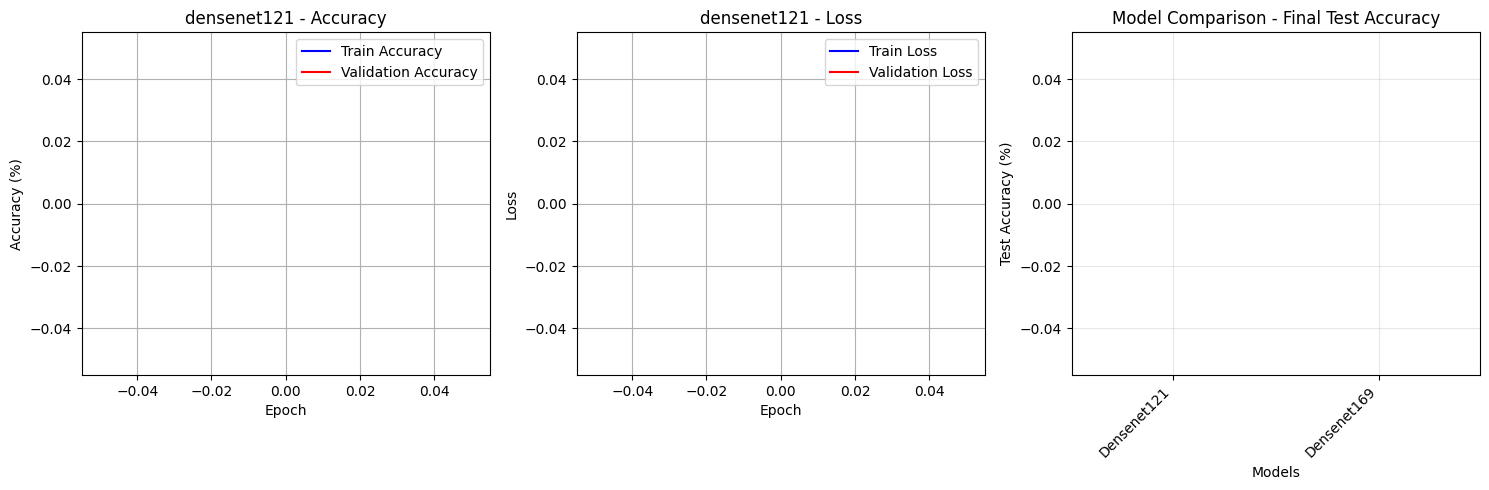

In [20]:
# Display final results
print("\n" + "="*90)
print("FINAL RESULTS SUMMARY")
print("="*90)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('final_test_accuracies', ascending=False)

print(f"{'Model':<20} {'Test Acc':<10} {'Val Acc':<10} {'Train Acc':<10} {'Train Time':<12} {'Epochs':<8}")
print("-" * 80)

for idx, row in results_df.iterrows():
    print(f"{row['model_names']:<20} {row['final_test_accuracies']:<10.2f} {row['val_accuracies']:<10.2f} {row['train_accuracies']:<10.2f} {row['train_times']:<12.2f} {row['best_epochs']:<8}")

# Find best model based on test accuracy
best_model_idx = results_df['final_test_accuracies'].idxmax()
best_model = results_df.loc[best_model_idx]

print(f"\nBest Model: {best_model['model_names']}")
print(f"Final Test Accuracy: {best_model['final_test_accuracies']:.2f}%")
print(f"Best Validation Accuracy: {best_model['val_accuracies']:.2f}%")
print(f"Best Train Accuracy: {best_model['train_accuracies']:.2f}%")
print(f"Training Time: {best_model['train_times']:.2f}s")
print(f"Epochs: {best_model['best_epochs']}")

# Example code to plot training curves for the best model
print(f"\nPlotting training curves for {best_model['model_names']}...")

best_idx = results_df.index[results_df['model_names'] == best_model['model_names']].tolist()[0]

plt.figure(figsize=(15, 5))

# Plot accuracies
plt.subplot(1, 3, 1)
epochs_range = range(1, len(results['train_acc_history'][best_idx]) + 1)
plt.plot(epochs_range, results['train_acc_history'][best_idx], 'b-', label='Train Accuracy')
plt.plot(epochs_range, results['val_acc_history'][best_idx], 'r-', label='Validation Accuracy')
plt.title(f'{best_model["model_names"]} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot losses
plt.subplot(1, 3, 2)
plt.plot(epochs_range, results['train_loss_history'][best_idx], 'b-', label='Train Loss')
plt.plot(epochs_range, results['val_loss_history'][best_idx], 'r-', label='Validation Loss')
plt.title(f'{best_model["model_names"]} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot comparison of all models' final test accuracies
plt.subplot(1, 3, 3)
model_names = [name.replace('_', ' ').title() for name in results_df['model_names']]
plt.bar(range(len(model_names)), results_df['final_test_accuracies'])
plt.title('Model Comparison - Final Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()